First set up for using Schnet on our crystal data.

In [1]:
import os
from pathlib import Path  #recommended path library for python3
import sys
import numpy as np
import matplotlib.pyplot as plt
import schnetpack as spk
from schnetpack.data import ASEAtomsData, BaseAtomsData, AtomsDataFormat, AtomsDataModule
import schnetpack.transform as trn
import torch
import torchmetrics
import pytorch_lightning as pl
import pickle
import pandas as pd
import schnet4class
# from pymatgen.io.ase import AseAtomsAdaptor as pase

INFO:numexpr.utils:Note: NumExpr detected 18 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
print(Path().resolve())  #current working directory
print(Path().absolute()) #file path in jupyter

/home/samariam/projects/chemheuristics
/home/samariam/projects/chemheuristics


#Important note!

I'm gonna use electron volt for the compulsory unit decleration to see if I can complete the classification workflow. But even if it works I'll need to fix it soon. 

First I'll try doing a regression and getting the round number (or closest number to label) as the class. Later I'll have to use classiification loss.

In [3]:
qm9tut = './qm9tut/lightning_logs'
if not os.path.exists('qm9tut/lightning_logs'):
    os.makedirs(qm9tut)
    
splitFile_path = Path('split.npz')
# splitFile_path = 'split.npz'

try:
    splitFile_path.unlink()
except OSError as e:
    print(e)
    splitFile_path = Path(qm9tut+'/'+str(splitFile_path))
    try:
        splitFile_path.unlink()
    except OSError as e:
        print(e)
        
datapath = Path('./class_dataset.db')
try:
    datapath.unlink()
except OSError as e:
    print(e)        
    
bestModel_path = Path(qm9tut+'/best_inference_model')
try:
    bestModel_path.unlink()
except OSError as e:
    print(e)        

[Errno 2] No such file or directory: 'split.npz'
[Errno 2] No such file or directory: 'qm9tut/lightning_logs/best_inference_model'


In [4]:
# try using the best_model to predict as the example. Just figure out the least amount of test data you can provide to the trainer.

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.device('cpu')     #gpu was busy
# torch.device('cuda:3')

device(type='cpu')

In [7]:
pAtoms = np.load("data_for_dev_try/PosAtomsUnder12.npy", allow_pickle=True)
tAtoms = np.load("data_for_dev_try/TheoAtomsUnder12.npy", allow_pickle=True)

In [8]:
print('The length of positive data is {} and the length of the theoretical data is {}'.format(len(pAtoms), len(tAtoms)))

The length of positive data is 1170 and the length of the theoretical data is 2752


In [9]:
np.random.seed(42)
np.random.shuffle(pAtoms)
np.random.shuffle(tAtoms)

In [10]:
mypAtoms = pAtoms[:100]
testpAtoms = pAtoms[-20:]
mytAtoms = tAtoms[:500]
testtAtoms = tAtoms[-100:]

In [11]:
# np.int32?

In [12]:
# pSynth = [np.array(1).flatten()]*len(mypAtoms)    #we need the array to have the shape (1,), hence we use flatten()
# tSynth = [np.array(0).flatten()]*len(mytAtoms)

# changed int64 to float32, didn't help the float dataset.
# pSynth = [np.array([1.], dtype=np.float32)[0].flatten()]*len(mypAtoms)    #we need the array to have the shape (1,), hence we use flatten()
# tSynth = [np.array([1.], dtype=np.float32)[0].flatten()]*len(mytAtoms)

pSynth = [np.array(1, dtype=np.int32).flatten()]*len(mypAtoms)    #we need the array to have the shape (1,), hence we use flatten()
tSynth = [np.array(0, dtype=np.int32).flatten()]*len(mytAtoms)

testpSynth = [np.array(1, dtype=np.int32).flatten()]*len(testpAtoms)    #here we prepare test data in the same format as the  training data.
testtSynth = [np.array(0, dtype=np.int32).flatten()]*len(testtAtoms)

In [13]:
pSynth[0], pSynth[0].shape

(array([1], dtype=int32), (1,))

In [14]:
crysData = np.concatenate([mypAtoms, mytAtoms])
testCrysData = np.concatenate([testpAtoms, testtAtoms])

targetData = [*pSynth, *tSynth]   #again, we need distinct arrays. np.concatenate would merge all in one array.
testTargetData = [*testpSynth, *testtSynth]   

In [15]:
crysdf = pd.DataFrame()
testCrysdf = pd.DataFrame()

In [16]:
crysdf['myatoms'] = crysData
testCrysdf['myatoms'] = testCrysData

In [17]:
crysdf['targets'] = targetData
testCrysdf['targets'] = testTargetData

In [18]:
print(targetData[0].shape, testTargetData[0].shape)      #each shape needs to be (1,)

(1,) (1,)


In [19]:
crysdf.targets = crysdf.targets.map(lambda crystalClass: dict(synth=np.array(crystalClass)) )     #changes targets fromat from array to dict with array val
testCrysdf.targets = testCrysdf.targets.map(lambda crystalClass: dict(synth=np.array(crystalClass)) )

In [20]:
print(crysdf.loc[0].targets)
# this needs to return {'synth':array([1 or 0])}

{'synth': array([1], dtype=int32)}


In [21]:
# we need to shuffle here to mix the positive and unlabaled data together.
crysdf = crysdf.sample(frac=1, random_state=1).reset_index(drop=True)     #simply shuffles the rows of the dataframe
testCrysdf = testCrysdf.sample(frac=1, random_state=1).reset_index(drop=True)     #simply shuffles the rows of the dataframe


In [22]:
# %rm split.npz
# %rm qm9tut/lightning_logs/split.npz

trainLength = round(len(crysdf)*.8)-2
# valLength = round(trainLength*.2)-2
valLength = round(len(crysdf)*.2)-2
testLength = len(crysdf)-(trainLength+valLength)

print('The #training data is {}, #validation data {} and #internal test data {}. '.format(trainLength, valLength, testLength))


The #training data is 478, #validation data 118 and #internal test data 4. 


In [23]:
# datapath = './class_dataset.db'
# datapath = './class_dataset2.db'
# %rm {datapath}
# %rm qm9tut/lightning_logs/best_inference_model
# %rm synth/lightning_logs/best_inference_model

class_dataset = ASEAtomsData.create(str(datapath), 
                                  distance_unit='Ang',
                                  property_unit_dict={'synth':int(1)}                                  
                        )


In [24]:
class_dataset.add_systems(np.array(crysdf.targets), np.array(crysdf.myatoms))  

In [25]:
# stop!

In [26]:
for p in class_dataset.available_properties:
    print('-', p)
print()

example = class_dataset[0]
print('Properties of molecule with id 0:')

for k, v in example.items():
    print('-', k, ':', v.shape)

- synth

Properties of molecule with id 0:
- _idx : torch.Size([1])
- synth : torch.Size([1])
- _n_atoms : torch.Size([1])
- _atomic_numbers : torch.Size([10])
- _positions : torch.Size([10, 3])
- _cell : torch.Size([1, 3, 3])
- _pbc : torch.Size([3])


In [27]:
example[ 'synth']

tensor([0.])

In [28]:
# stop! 
# is the synth property above still integer?

In [29]:
crysData = AtomsDataModule(datapath=datapath,
                   batch_size=20,
                #    batch_size=100,
    num_train=trainLength,
    num_val=valLength,
    transforms=[
        trn.ASENeighborList(cutoff=5.),
        # trn.RemoveOffsets('fepa', remove_mean=True, remove_atomrefs=True),
        # trn.CastTo32()
    ],
    property_units={'synth':int(1)},
    # property_units={'synth':'eV'},
    # property_units={'synth':'arb. unit'},     #need to fix this
    num_workers=1,
    split_file=os.path.join(qm9tut, "split.npz"),
    pin_memory=False, # set to false, when not using a GPU
    # pin_memory=True, # set to false, when not using a GPU
    load_properties=['synth'], #only load U0 property
    )

In [30]:
# dir(crysData)

In [31]:
crysData.prepare_data()


In [32]:
crysData.setup()

In [33]:
crysData.train_dataset[0]['synth']
# this is available only after we run prepare_data and setup. Probbaby changes somewhere there.

tensor([0.])

In [34]:
print("The total length of the data set is", len(class_dataset))
print("The length of the training set is", trainLength)
print("The length of the validation set is", valLength)
print("The length of the test set is", len(class_dataset)-(trainLength+valLength))

The total length of the data set is 600
The length of the training set is 478
The length of the validation set is 118
The length of the test set is 4


In [35]:
# atomrefs = crysData.train_dataset.atomrefs
# atomrefs

In [36]:
# stop!
crysdf.loc[0].targets

{'synth': array([0], dtype=int32)}

In [37]:
crysData.dataset[0]['synth']

tensor([0.])

In [38]:
means, stddevs = crysData.get_stats(
    'synth', divide_by_atoms=True, remove_atomref=True
    # 'synth', divide_by_atoms=True, remove_atomref=True
)
print('Mean atomization energy / atom:', means.item())
print('Std. dev. atomization energy / atom:', stddevs.item())
# This doesn't work when no test data is given, and it has no docstring. Does it calculate the mean and and std of test data?

100%|██████████| 24/24 [00:09<00:00,  2.62it/s]

Mean atomization energy / atom: 0.027122163654121897
Std. dev. atomization energy / atom: 0.06723066669679122


In [39]:
cutoff = 5
radial_basis = spk.nn.GaussianRBF(n_rbf=20, cutoff=cutoff)
n_atom_basis = 30
n_filters = 64

In [40]:
pairwise_distance = spk.atomistic.PairwiseDistances() # calculates pairwise distances between atoms

In [41]:
# from torch.nn import functional
import torch.nn as nn
import torch
from typing import Callable

In [42]:
schnet = spk.representation.SchNet(
    n_atom_basis=n_atom_basis, n_filters=n_filters, n_interactions=3, radial_basis=radial_basis,
    
    cutoff_fn = spk.nn.CosineCutoff(cutoff), 
    # activation=functional.sigmoid   #this might change all the activations
)


In [43]:
pred_synth = spk.atomistic.Atomwise(n_in=n_atom_basis, output_key='synth')

In [44]:
nnpot = spk.model.NeuralNetworkPotential(
    representation=schnet,
    input_modules=[pairwise_distance],
    output_modules=[pred_synth], 
    postprocessors=[trn.CastTo64(), trn.AddOffsets('synth', add_mean=True, add_atomrefs=False)]  
)

In [45]:
# output_synth = spk.task.ModelOutput(
#     name='synth',
#     loss_fn=torch.nn.MSELoss(), #this+metrics below later changes to BCELoss 
#     loss_weight=1.,
#     metrics={
#         "MAE": torchmetrics.MeanAbsoluteError()
#     }
# )

In [46]:
# def my_loss(input, target):
#     classInput = input.int()
#     pos_weight = torch.ones([64])
#     criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
#     return criterion(input, target)

In [47]:
# from torch.nn.modules.loss import _Loss
# from typing import Callable, Optional

# class myBCEWithLogitsLoss(_Loss):

#     def __init__(self, weight: Optional[torch.Tensor] = None, size_average=None, reduce=None, reduction: str = 'mean',
#                  pos_weight: Optional[torch.Tensor] = None) -> None:
#         super(myBCEWithLogitsLoss, self).__init__(size_average, reduce, reduction)
#         self.register_buffer('weight', weight)
#         self.register_buffer('pos_weight', pos_weight)
#         self.weight: Optional[torch.Tensor]
#         self.pos_weight: Optional[torch.Tensor]

#     def forward(self, input, target):
#         # target2=target.int()
#         # return F.binary_cross_entropy_with_logits(input, target2,
#         return F.binary_cross_entropy_with_logits(input, target,
#                                                   self.weight,
#                                                   pos_weight=self.pos_weight,
#                                                   reduction=self.reduction)



In [48]:

output_synth = spk.task.ModelOutput(
    name='synth',
    # loss_fn=myBCEWithLogitsLoss(), 
    # loss_fn=torch.nn.BCEWithLogitsLoss(), 
    # loss_fn=torch.nn.CrossEntropyLoss(), 
    loss_fn=torch.nn.BCELoss(), 
    loss_weight=1.,
    metrics={
        "Accur": torchmetrics.Accuracy()   #potential alternatives: AUROC(increases the area under ROC curve), AveragePrecision (summarises the precision-recall curve)
    }
)

In [49]:
task = spk.task.AtomisticTask(
    model=nnpot,
    # outputs=[output_fepa],
    outputs=[output_synth],
    optimizer_cls=torch.optim.AdamW,
    optimizer_args={"lr": 1e-4}
)

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpi3xi8nq1
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpi3xi8nq1/_remote_module_non_scriptable.py


In [50]:
logger = pl.loggers.TensorBoardLogger(save_dir=qm9tut)
callbacks = [
    spk.train.ModelCheckpoint(
        inference_path=os.path.join(qm9tut, "best_inference_model"),
        save_top_k=1,
        monitor="val_loss"
    )
]


In [51]:

trainer = pl.Trainer(
    # devices=2,   #error says a strategy is selected which is not compatible with interactive mode; regardless of choosing a "compatible" strategy.
    # auto_select_gpus = False,
    # gpus=[0],  #this selects the number of gpus to use, not the exact one.
    # auto_select_gpus = True,
    # gpus=1,  #this selects the number of gpus to use, not the exact one.
    accelerator='cpu',
    strategy=None,
    callbacks=callbacks,
    logger=logger,
    default_root_dir=qm9tut,
    max_epochs=3, # for testing, we restrict the number of epochs
)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/samariam/anaconda3/envs/schDev/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1814: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=4)`.
  rank_zero_warn(


We need sigmoid before cross_entropy loss


In [52]:
# trainer.fit(task, train_dataloaders=train_loader, val_dataloaders=val_loader)#, datamodule=qm9data)
trainer.fit(task, datamodule=crysData)

100%|██████████| 24/24 [00:09<00:00,  2.61it/s]

  | Name    | Type                   | Params
---------------------------------------------------
0 | model   | NeuralNetworkPotential | 34.4 K
1 | outputs | ModuleList             | 0     
---------------------------------------------------
34.4 K    Trainable params
0         Non-trainable params
34.4 K    Total params
0.138     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/samariam/anaconda3/envs/schDev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 18 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


RuntimeError: expected scalar type Float but found Double

In [ ]:
class_dataset[0]

{'_idx': tensor([0]),
 'synth': tensor([0.]),
 '_n_atoms': tensor([10]),
 '_atomic_numbers': tensor([57, 57, 22, 30,  8,  8,  8,  8,  8,  8]),
 '_positions': tensor([[ 9.5927e+00,  1.2888e-16,  3.4652e+00],
         [ 3.1952e+00, -5.0175e-17,  1.1542e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 6.3940e+00,  0.0000e+00,  2.3097e+00],
         [ 5.7309e+00, -1.2531e+00,  7.4232e-01],
         [ 5.4632e+00,  1.7081e+00,  1.4835e+00],
         [ 4.7258e+00, -4.5499e-01,  3.5249e+00],
         [ 7.0570e+00,  1.2531e+00,  3.8770e+00],
         [ 8.0621e+00,  4.5499e-01,  1.0945e+00],
         [ 7.3247e+00, -1.7081e+00,  3.1359e+00]], dtype=torch.float64),
 '_cell': tensor([[[ 4.8189, -2.8357,  0.0000],
          [ 4.8189,  2.8357,  0.0000],
          [ 3.1502,  0.0000,  4.6194]]], dtype=torch.float64),
 '_pbc': tensor([True, True, True])}

In [ ]:
stop

Type:        dtype
String form: torch.int32
File:        ~/anaconda3/envs/schDev/lib/python3.9/site-packages/torch/__init__.py
Docstring:   <no docstring>


In [ ]:
best_model = torch.load(os.path.join(qm9tut, 'best_inference_model'))

In [ ]:
trainer.test(task, crysData)

/home/samariam/anaconda3/envs/schDev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 18 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/samariam/anaconda3/envs/schDev/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:72: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    192.18838500976562     │
│      test_synth_MAE       │    13.643445014953613     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 192.18838500976562, 'test_synth_MAE': 13.643445014953613}]

When training on class labels: [{'test_loss': 2.7045037746429443, 'test_synth_MAE': 1.297343373298645}]
It seems like the test_loss magnitude is changes more with the target?


after 3 epochs: [{'test_loss': 11.951684951782227, 'test_fepa_MAE': 2.681666851043701}]

after 10 epochs: [{'test_loss': 2.2840123176574707, 'test_fepa_MAE': 1.183426022529602}]

In [ ]:
stop!

SyntaxError: invalid syntax (3319058519.py, line 1)

In [ ]:
# trainer.predict(task, crysData)

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir=./qm9tut/lightning_logs

In [ ]:
stop!

SyntaxError: invalid syntax (3319058519.py, line 1)

In [ ]:
# crysData.setup()  #does not seem to make a difference

In [ ]:
# for i,batch in enumerate(crysData.test_dataloader()):
#     print('starting {}'.format(i)) 
#     result = best_model(batch)
#     err = sum(abs(batch['fepa'].detach().numpy()-result['fepa'].detach().numpy()))
#     print('The absolute error is',err)

##### Testing with data not already seen by the dataloader

In [ ]:
converter = spk.interfaces.AtomsConverter(neighbor_list=trn.ASENeighborList(cutoff=5.), dtype=torch.float32)

In [ ]:
best_model = best_model.to('cpu')

In [ ]:
# testCrysdf.head()

In [ ]:
testCrysdf.tail()

,myatoms,targets
115,"(Atom('Ba', [6.3479265, 6.3479265, 6.3479265],...",{'synth': [1]}
116,"(Atom('Sr', [-6.554058096241989e-18, 6.5540580...",{'synth': [0]}
117,"(Atom('Cr', [2.9588875, 1.955123, 6.3714835], ...",{'synth': [1]}
118,"(Atom('Cs', [0.012741762408, 0.0, 3.3283214304...",{'synth': [0]}
119,"(Atom('Co', [2.854327, 2.876323999999999, 4.22...",{'synth': [0]}


In [ ]:
def pred_test(x):
    inputs = converter(x)
    pred = best_model(inputs)
    pred_arr = next(iter(pred.values())).detach().numpy()    #dict_value to array
    if (1-pred_arr<pred_arr):
        pred_arr = 1
    else:
        pred_arr = 0
    return pred_arr

In [ ]:
predSynth = []
    
for ind, row in testCrysdf.iterrows():
    # print(ind) 
    # print(row)
    inputs = converter(row['myatoms'])
    pred = best_model(inputs)
    pred_arr = next(iter(pred.values())).detach().numpy()    #dict_value to array
    # print(pred_arr)
    if (1-pred_arr<pred_arr):
        pred_arr = 1
    else:
        pred_arr = 0
    predSynth.append([ind,pred_arr])
    
    
# for datum in predSynth:     #changing the reg output to class labels based on distance from label value
#     if (1-datum[1]<datum[1]):
#         datum[1] = 1
#     else:
#         datum[1] = 0

In [ ]:
# pred_col = pd.Series(data=[datum[1] for datum in predSynth], index=[datum[0] for datum in predSynth])
pred_col = pd.DataFrame(data=[datum[1] for datum in predSynth], 
            index=[datum[0] for datum in predSynth], columns=['test'] )

In [ ]:
testCrysdf['mycol'] = testCrysdf.myatoms.apply(lambda x: pred_test(x))
# df1 = df.apply(lambda x: x * x)

In [ ]:
testCrysdf

,myatoms,targets,0,mycol
0,"(Atom('O', [0.0, 0.0, 1.94282375], magmom=-0.0...",{'synth': [0]},0,0
1,"(Atom('W', [1.554401, -0.8974354615340001, 8.2...",{'synth': [0]},0,0
2,"(Atom('La', [9.59190380106, -7.207891786720211...",{'synth': [0]},1,1
3,"(Atom('Yb', [0.0, 0.0, 0.0], magmom=0.018, ind...",{'synth': [0]},0,0
4,"(Atom('Cr', [-2.7845342297320004, 2.5697284645...",{'synth': [0]},1,1
...,...,...,...,...
115,"(Atom('Ba', [6.3479265, 6.3479265, 6.3479265],...",{'synth': [1]},1,1
116,"(Atom('Sr', [-6.554058096241989e-18, 6.5540580...",{'synth': [0]},1,1
117,"(Atom('Cr', [2.9588875, 1.955123, 6.3714835], ...",{'synth': [1]},1,1
118,"(Atom('Cs', [0.012741762408, 0.0, 3.3283214304...",{'synth': [0]},1,1


In [ ]:
# cur_it = 5
testCrysdf = testCrysdf.merge(pred_col, left_index=True, right_index=True, how='outer')

In [ ]:
# cur_it = 5
testCrysdf.head()

,myatoms,targets,0
0,"(Atom('O', [0.0, 0.0, 1.94282375], magmom=-0.0...",{'synth': [0]},0
1,"(Atom('W', [1.554401, -0.8974354615340001, 8.2...",{'synth': [0]},0
2,"(Atom('La', [9.59190380106, -7.207891786720211...",{'synth': [0]},1
3,"(Atom('Yb', [0.0, 0.0, 0.0], magmom=0.018, ind...",{'synth': [0]},0
4,"(Atom('Cr', [-2.7845342297320004, 2.5697284645...",{'synth': [0]},1


In [ ]:
# how to check a data point or accuracy:
acc = []
for d in predSynth:
    acc.append(next(iter(testCrysdf.iloc[d[0]].targets.values()))==d[1])

In [ ]:
sum(acc)/len(acc) #this doesn't mean much because we don't know about unlabele data.
# we want to group the positive label data points together anc check the rate of true positives there.

array([0.36666667])

In [ ]:
STOP!

In [ ]:
res = [datum['fepa'].detach().numpy() for datum in predFepa]
fepaTestVals = [datum['fepa'] for datum in fepaTest]

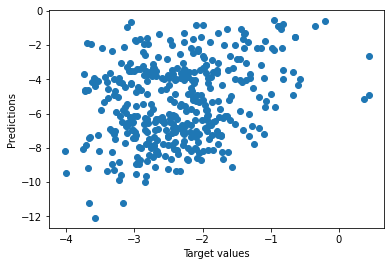

In [ ]:
plt.scatter(fepaTestVals, res)
plt.xlabel("Target values");
plt.ylabel("Predictions");

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# these are different test data

In [ ]:
mean_absolute_error(fepaTestVals, res)

3.146852985290763

In [ ]:
mean_absolute_error(fepaTestVals, res)

3.2532482934916755

In [ ]:
mean_squared_error(fepaTestVals, res)

13.906101673587742

In [ ]:
mean_squared_error(fepaTestVals, res)

19.34585335907423

In [ ]:
crysData.test_dataloader().pin_memory_device = 'cpu'

''

code we might use later:

In [ ]:
# class MetricTracker(pl.callbacks.Callback):
#     def __init__(self):
#         self.val_error_batch   = []
#         self.val_error         = []
#         self.train_error_batch = []
#         self.train_error       = []

#     def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
#         self.train_error_batch.append(outputs['loss'].item())

#     def on_train_epoch_end(self, *args, **kwargs):
#         self.train_error.append(np.mean(self.train_error_batch))
#         self.train_error_batch = []

#     def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx):
#         self.val_error_batch.append(outputs['val_loss'].item())

#     def on_validation_epoch_end(self, trainer, pl_module):
#         self.val_error.append(np.mean(self.val_error_batch))
#         self.val_error_batch = []

In [ ]:
# dummy_synth = pd.get_dummies(crysdf['targets'],prefix = 'synth')
# crysdf = pd.merge(crysdf,dummy_synth,
#     left_index=True,
#     right_index=True,
# )
# crysdf.head()

In [ ]:
# td = [batch for batch in crysData.test_dataloader()]

In [ ]:
# # the log file is not saved, at least where it was before. Have a look around, perhaps clean the folder
# # or try in a different TEST folder and try again.
# import matplotlib.pyplot as plt
# from ase.units import kcal, mol

# results = np.loadtxt(os.path.join(qm9tut, 'log.csv'), skiprows=1, delimiter=',')

# time = results[:,0]-results[0,0]
# learning_rate = results[:,1]
# train_loss = results[:,2]
# val_loss = results[:,3]
# val_mae = results[:,4]

# print('Final validation MAE:', np.round(val_mae[-1], 2), 'eV =',
#       np.round(val_mae[-1] / (kcal/mol), 2), 'kcal/mol')

# plt.figure(figsize=(14,5))
# plt.subplot(1,2,1)
# plt.plot(time, val_loss, label='Validation')
# plt.plot(time, train_loss, label='Train')
# plt.yscale('log')
# plt.ylabel('Loss [eV]')
# plt.xlabel('Time [s]')
# plt.legend()
# plt.subplot(1,2,2)
# plt.plot(time, val_mae)
# plt.ylabel('mean abs. error [eV]')
# plt.xlabel('Time [s]')
# # plt.show()
# # plt.savefig('tempfigDev.jpg')